In [1]:
%cd /content
!rm -rf pneumonia_detection
!git clone -b main https://github.com/hanvocado/pneumonia_detection.git
%cd /content/pneumonia_detection
!git status
!git branch


/content
Cloning into 'pneumonia_detection'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 127 (delta 5), reused 21 (delta 5), pack-reused 92 (from 1)
Receiving objects: 100% (127/127), 108.86 MiB | 15.87 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/pneumonia_detection
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
* main


In [2]:
!pip install -r requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.8 MB/s eta 0:00:00


In [3]:
%cd /content/pneumonia_detection

!jupyter nbconvert --to notebook --execute src/preprocess/download_and_preprocess.ipynb --output /content/out_download_and_preprocess.ipynb



/content/pneumonia_detection
[NbConvertApp] Converting notebook src/preprocess/download_and_preprocess.ipynb to notebook
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
[NbConvertApp] Writing 6809213 bytes to /content/out_download_and_preprocess.ipynb


In [4]:
%cd /content/pneumonia_detection
!jupyter nbconvert --to notebook --execute src/preprocess/split_dataset.ipynb \
  --output /content/out_split_dataset.ipynb



/content/pneumonia_detection
[NbConvertApp] Converting notebook src/preprocess/split_dataset.ipynb to notebook
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
[NbConvertApp] Writing 1196873 bytes to /content/out_split_dataset.ipynb


In [5]:
!nvidia-smi


Fri Dec 19 14:38:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
%cd /content/pneumonia_detection
!ls


/content/pneumonia_detection
data_processed	data_processed_new  models  README.md  requirements.txt  src


In [7]:
!pip -q install torch torchvision scikit-learn matplotlib numpy


In [8]:
import random, numpy as np, torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print("Seed set to 42")


Seed set to 42


# **Khai báo đường dẫn dataset**

In [10]:
import os

DATA_DIR = "/content/pneumonia_detection/data_processed_new"

train_dir = os.path.join(DATA_DIR, "train")
val_dir   = os.path.join(DATA_DIR, "val")
test_dir  = os.path.join(DATA_DIR, "test")

print("Train exists:", os.path.isdir(train_dir))
print("Val exists:",   os.path.isdir(val_dir))
print("Test exists:",  os.path.isdir(test_dir))

print("Train classes:", os.listdir(train_dir))


Train exists: True
Val exists: True
Test exists: True
Train classes: ['PNEUMONIA', 'NORMAL']


# **Tạo DataLoader cho ResNet pretrained**

In [11]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 2

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

train_ds = ImageFolder(train_dir, transform=train_tf)
val_ds   = ImageFolder(val_dir,   transform=val_tf)
test_ds  = ImageFolder(test_dir,  transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("class_to_idx:", train_ds.class_to_idx)
print("train/val/test:", len(train_ds), len(val_ds), len(test_ds))


class_to_idx: {'NORMAL': 0, 'PNEUMONIA': 1}
train/val/test: 5982 877 880


# **Tạo ResNet18 pretrained và thay FC = 2 classes**

In [12]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: NORMAL vs PNEUMONIA
model = model.to(device)



total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Total parameters: 11,177,538
Trainable parameters: 11,177,538


# **Phase 1 — Transfer Learning (Freeze backbone, train FC)**

**Freeze toàn bộ trừ FC**

In [13]:
for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True


**Loss/Optimizer**

In [14]:
import numpy as np
from collections import Counter

# Đếm phân bố lớp train để weight loss
train_labels = [y for _, y in train_ds.samples]
counts = Counter(train_labels)
print("Train label counts:", counts)

# weight = tổng / (num_classes * count_class)
total = sum(counts.values())
class_weights = [total / (2 * counts[i]) for i in range(2)]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

import torch.optim as optim
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)


Train label counts: Counter({0: 2991, 1: 2991})
Class weights: tensor([1., 1.], device='cuda:0')


**Viết hàm train/eval**

In [15]:
from sklearn.metrics import accuracy_score

def run_one_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    all_preds, all_labels = [], []
    running_loss = 0.0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.set_grad_enabled(is_train):
            logits = model(x)
            loss = criterion(logits, y)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.detach().cpu())
        all_labels.append(y.detach().cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def eval_full(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    running_loss = 0.0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            logits = model(x)
            loss = criterion(logits, y)

            running_loss += loss.item() * x.size(0)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    avg_loss = running_loss / len(loader.dataset)
    acc  = (all_preds == all_labels).mean()
    prec = precision_score(all_labels, all_preds)
    rec  = recall_score(all_labels, all_preds)
    f1   = f1_score(all_labels, all_preds)

    # Specificity (NORMAL recall) để biết FP nhiều hay ít
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp + 1e-12)
    balanced_acc = 0.5 * (rec + specificity)

    return avg_loss, acc, prec, rec, f1, specificity, balanced_acc


**Train Phase 1**

In [17]:
import os
os.makedirs("models", exist_ok=True)

PHASE1_EPOCHS = 5
best_f1 = -1.0
best_path = "models/resnet18_best.pth"
best_epoch = None

hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f1": []}

for epoch in range(1, PHASE1_EPOCHS + 1):
    tr_loss, tr_acc = run_one_epoch(model, train_loader, optimizer=optimizer)
    va_loss, va_acc, va_prec, va_rec, va_f1, va_spec, va_bacc = eval_full(model, val_loader)

    hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
    hist["val_loss"].append(va_loss);   hist["val_acc"].append(va_acc)
    hist["val_f1"].append(va_f1)

    if va_f1 > best_f1:
        best_f1 = va_f1
        best_epoch = ("Phase1", epoch)
        torch.save(model.state_dict(), best_path)

    print(f"[Phase1][{epoch}/{PHASE1_EPOCHS}] "
          f"train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | "
          f"val_loss={va_loss:.4f} val_acc={va_acc:.4f} val_f1={va_f1:.4f} "
          f"spec={va_spec:.4f} bacc={va_bacc:.4f}")

print("Best so far:", best_epoch, "best_f1=", best_f1, "saved:", best_path)


[Phase1][1/5] train_loss=0.3828 train_acc=0.8420 | val_loss=0.4345 val_acc=0.8233 val_f1=0.8634 spec=0.9789 bacc=0.8723
[Phase1][2/5] train_loss=0.2794 train_acc=0.8883 | val_loss=0.2754 val_acc=0.8837 val_f1=0.9151 spec=0.9494 bacc=0.9044
[Phase1][3/5] train_loss=0.2580 train_acc=0.8985 | val_loss=0.2362 val_acc=0.9019 val_f1=0.9296 spec=0.9409 bacc=0.9142
[Phase1][4/5] train_loss=0.2433 train_acc=0.9029 | val_loss=0.2978 val_acc=0.8734 val_f1=0.9066 spec=0.9578 bacc=0.9000
[Phase1][5/5] train_loss=0.2373 train_acc=0.9077 | val_loss=0.2325 val_acc=0.9042 val_f1=0.9315 spec=0.9367 bacc=0.9144
Best so far: ('Phase1', 5) best_f1= 0.9314845024469821 saved: models/resnet18_best.pth


# **Phase 2 — Fine-tuning (Unfreeze layer4 + FC)**

**Unfreeze layer4 và fc**

In [18]:
for name, p in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        p.requires_grad = True
    else:
        p.requires_grad = False


**Optimizer LR nhỏ hơn**

In [19]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


**Train Phase 2**

In [20]:
PHASE2_EPOCHS = 5

for epoch in range(1, PHASE2_EPOCHS + 1):
    tr_loss, tr_acc = run_one_epoch(model, train_loader, optimizer=optimizer)
    va_loss, va_acc, va_prec, va_rec, va_f1, va_spec, va_bacc = eval_full(model, val_loader)

    hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
    hist["val_loss"].append(va_loss);   hist["val_acc"].append(va_acc)
    hist["val_f1"].append(va_f1)

    if va_f1 > best_f1:
        best_f1 = va_f1
        best_epoch = ("Phase2", epoch)
        torch.save(model.state_dict(), best_path)

    print(f"[Phase2][{epoch}/{PHASE2_EPOCHS}] "
          f"train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | "
          f"val_loss={va_loss:.4f} val_acc={va_acc:.4f} val_f1={va_f1:.4f} "
          f"spec={va_spec:.4f} bacc={va_bacc:.4f}")

print("Best final:", best_epoch, "best_f1=", best_f1, "saved:", best_path)


[Phase2][1/5] train_loss=0.1760 train_acc=0.9345 | val_loss=0.1623 val_acc=0.9373 val_f1=0.9556 spec=0.9705 bacc=0.9477
[Phase2][2/5] train_loss=0.1015 train_acc=0.9637 | val_loss=0.1153 val_acc=0.9498 val_f1=0.9651 spec=0.9451 bacc=0.9484
[Phase2][3/5] train_loss=0.0798 train_acc=0.9697 | val_loss=0.0871 val_acc=0.9726 val_f1=0.9811 spec=0.9705 bacc=0.9720
[Phase2][4/5] train_loss=0.0674 train_acc=0.9748 | val_loss=0.0972 val_acc=0.9738 val_f1=0.9820 spec=0.9578 bacc=0.9687
[Phase2][5/5] train_loss=0.0619 train_acc=0.9781 | val_loss=0.0890 val_acc=0.9692 val_f1=0.9790 spec=0.9283 bacc=0.9563
Best final: ('Phase2', 4) best_f1= 0.9819890368050117 saved: models/resnet18_best.pth


# **Đánh giá trên test: Accuracy, Precision, Recall, F1, ROC-AUC, Confusion Matrix**

Loaded best checkpoint: models/resnet18_best.pth
TEST METRICS
Accuracy        : 0.9704545454545455
Precision       : 0.9842767295597484
Recall          : 0.9750778816199377
F1-score        : 0.9796557120500783
ROC-AUC         : 0.9962106337862248
Specificity     : 0.957983193277307
Balanced Acc    : 0.9665305374486224


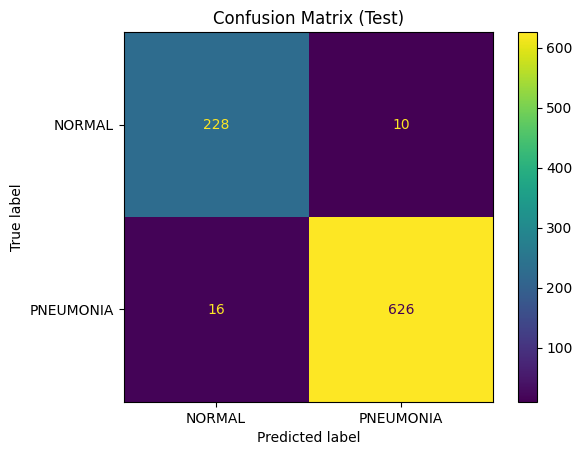

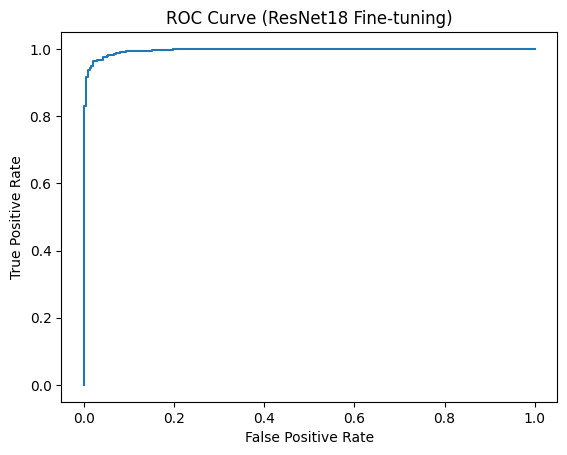

In [22]:
# ===== LOAD BEST CHECKPOINT BEFORE TEST =====
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)

# Load best checkpoint
best_ckpt = "models/resnet18_best.pth"
if os.path.exists(best_ckpt):
    model.load_state_dict(torch.load(best_ckpt, map_location=device))
    print("Loaded best checkpoint:", best_ckpt)
else:
    print("Best checkpoint not found, using current model weights.")

model.eval()

all_probs, all_preds, all_labels = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)

        logits = model(x)
        probs = torch.softmax(logits, dim=1)[:, 1]  # P(PNEUMONIA)
        preds = torch.argmax(logits, dim=1)

        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())
        all_labels.append(y)  # y đang ở CPU rồi

all_probs  = torch.cat(all_probs).numpy()
all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# ===== METRICS =====
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec  = recall_score(all_labels, all_preds)
f1   = f1_score(all_labels, all_preds)
auc  = roc_auc_score(all_labels, all_probs)

cm = confusion_matrix(all_labels, all_preds)  # [[TN, FP],[FN, TP]]
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp + 1e-12)  # NORMAL recall
balanced_acc = 0.5 * (rec + specificity)

print("TEST METRICS")
print("Accuracy        :", acc)
print("Precision       :", prec)
print("Recall          :", rec)
print("F1-score        :", f1)
print("ROC-AUC         :", auc)
print("Specificity     :", specificity)
print("Balanced Acc    :", balanced_acc)

# ===== CONFUSION MATRIX =====
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.classes)
disp.plot()
plt.title("Confusion Matrix (Test)")
plt.show()

# ===== ROC CURVE =====
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ResNet18 Fine-tuning)")
plt.show()


# **Vẽ Learning Curve (Loss/Accuracy)**

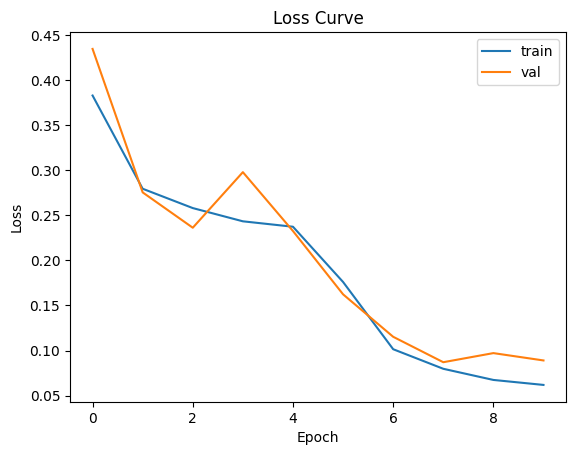

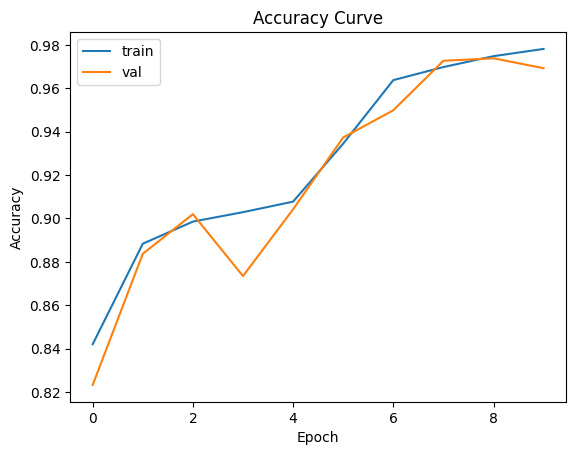

In [23]:
plt.figure()
plt.plot(hist["train_loss"])
plt.plot(hist["val_loss"])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

plt.figure()
plt.plot(hist["train_acc"])
plt.plot(hist["val_acc"])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()


In [24]:
import os, time
os.makedirs("models", exist_ok=True)

save_path = f"models/resnet18_finetune_{int(time.time())}.pth"
torch.save({
    "model_state": model.state_dict(),
    "class_to_idx": train_ds.class_to_idx,
    "img_size": (224, 224),
    "imagenet_norm": {"mean":[0.485,0.456,0.406], "std":[0.229,0.224,0.225]},
    "history": hist
}, save_path)

print("Saved to:", save_path)


Saved to: models/resnet18_finetune_1766155666.pth


In [26]:
from google.colab import drive
drive.mount("/content/drive")
!mkdir -p /content/drive/MyDrive/colab_backup
%cd /content
!zip -r /content/drive/MyDrive/colab_backup/pneumonia_detection_backup.zip pneumonia_detection


Streaming output truncated to the last 5000 lines.
  adding: pneumonia_detection/data_processed_new/train/PNEUMONIA/person578_virus_1122.jpeg (deflated 0%)
  adding: pneumonia_detection/data_processed_new/train/PNEUMONIA/person62_bacteria_298.jpeg (deflated 0%)
  adding: pneumonia_detection/data_processed_new/train/PNEUMONIA/person1288_bacteria_3251.jpeg (deflated 0%)
  adding: pneumonia_detection/data_processed_new/train/PNEUMONIA/person300_bacteria_1421.jpeg (deflated 0%)
  adding: pneumonia_detection/data_processed_new/train/PNEUMONIA/person506_bacteria_2136.jpeg (deflated 0%)
  adding: pneumonia_detection/data_processed_new/train/PNEUMONIA/person1629_bacteria_4299.jpeg (deflated 0%)
  adding: pneumonia_detection/data_processed_new/train/PNEUMONIA/person1620_bacteria_4272.jpeg (deflated 0%)
  adding: pneumonia_detection/data_processed_new/train/PNEUMONIA/person371_bacteria_1702.jpeg (deflated 0%)
  adding: pneumonia_detection/data_processed_new/train/PNEUMONIA/person1728_bacteria_45